In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Validation/Validation/Healthy/9d0f6e60819f9a5a.jpg
/kaggle/input/Validation/Validation/Healthy/9ccf708985967f09.jpg
/kaggle/input/Validation/Validation/Healthy/9ccbc2c5d1aaf078.jpg
/kaggle/input/Validation/Validation/Healthy/9bdcc23296db1516.jpg
/kaggle/input/Validation/Validation/Healthy/9cb97f87870407f0.jpg
/kaggle/input/Validation/Validation/Healthy/9bf9cca507923334.jpg
/kaggle/input/Validation/Validation/Healthy/9c077ad23a231abb.jpg
/kaggle/input/Validation/Validation/Healthy/9d6a6499354e3197.jpg
/kaggle/input/Validation/Validation/Healthy/9c3f1c10ba54ed56.jpg
/kaggle/input/Validation/Validation/Healthy/9d6acb154f9932c8.jpg
/kaggle/input/Validation/Validation/Healthy/9bd4cc8c52e9d52a.jpg
/kaggle/input/Validation/Validation/Healthy/9cb09eb2cabfc700.jpg
/kaggle/input/Validation/Validation/Healthy/9be41b823d13e3c6.jpg
/kaggle/input/Validation/Validation/Healthy/9c527f2a43e07a9c.jpg
/kaggle/input/Validation/Validation/Healthy/9ce01ba1856fc6ad.jpg
/kaggle/input/Validation/

In [2]:
# importing
import os

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras as k
from keras.models import Sequential
from keras.layers import Conv2D,BatchNormalization,Activation,GlobalAveragePooling2D,Dropout,Dense,MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

2025-12-03 18:25:53.332704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764786353.488657      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764786353.535567      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
# Storing Dataframe addresses
train=r'/kaggle/input/Train/Train'
test=r'/kaggle/input/Test/Test'
val=r'/kaggle/input/Validation/Validation'

****
# Data Augmentation
****

In [4]:
img_size=(224,224)
batch_size=32

# Scaling of Pixel Values for Training data
# Little Augmentation of the Training data for better results :)
trdata=ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

# Scaling of pixel values for Testing and Validation sets
tegen=ImageDataGenerator(rescale=1.0/255)
valgen=ImageDataGenerator(rescale=1.0/255)

In [5]:
traing=trdata.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)
testg = tegen.flow_from_directory(
    test,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='rgb', 
    class_mode='categorical',
    shuffle=False
)
valg = valgen.flow_from_directory(
    val,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)

Found 1322 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


****
# Displaying Images and Distribution of Classes
****

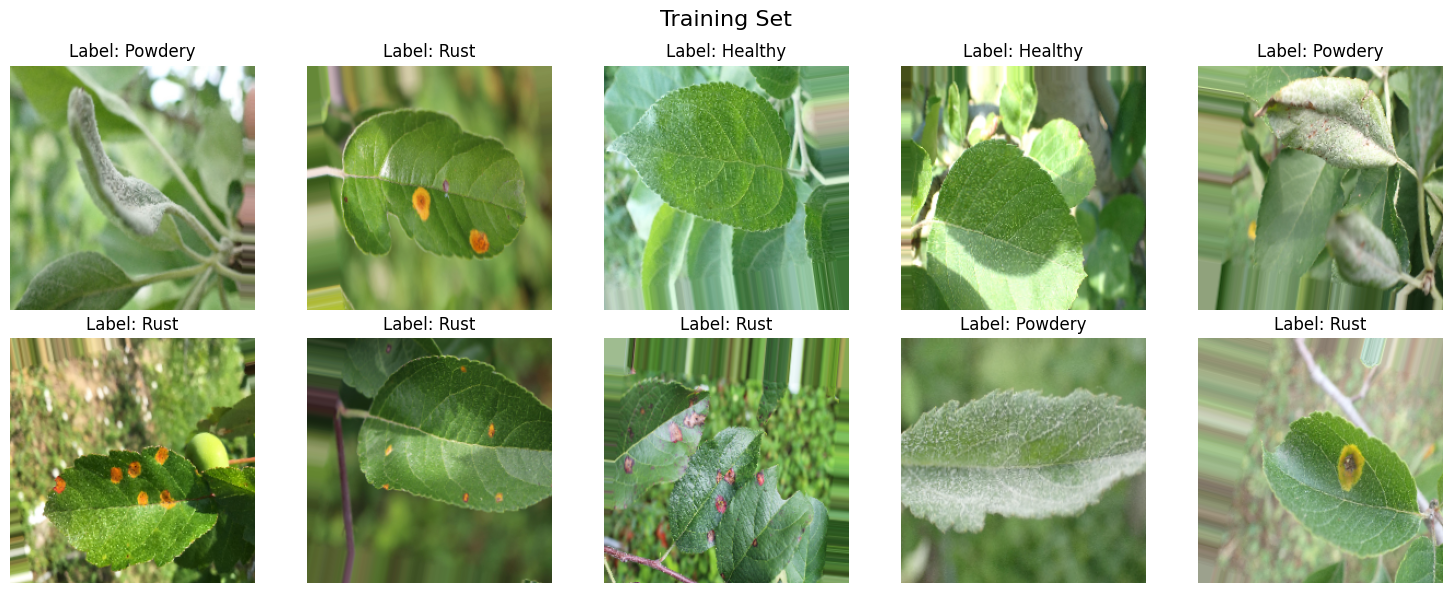

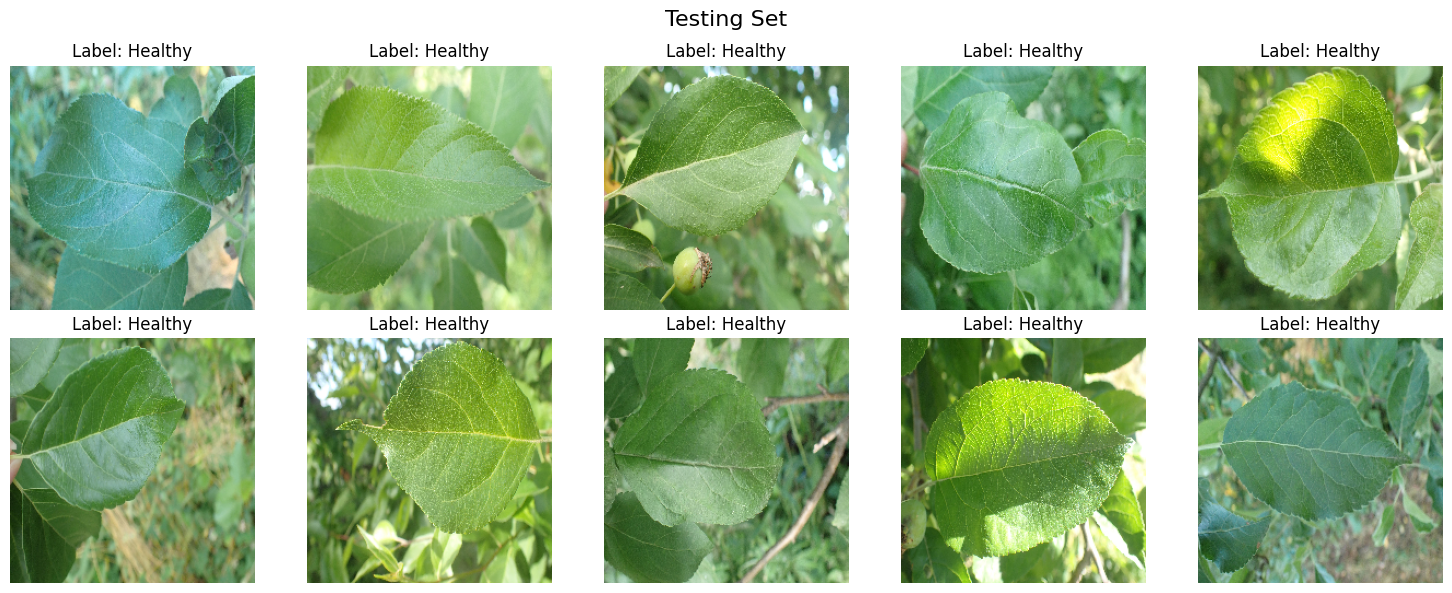

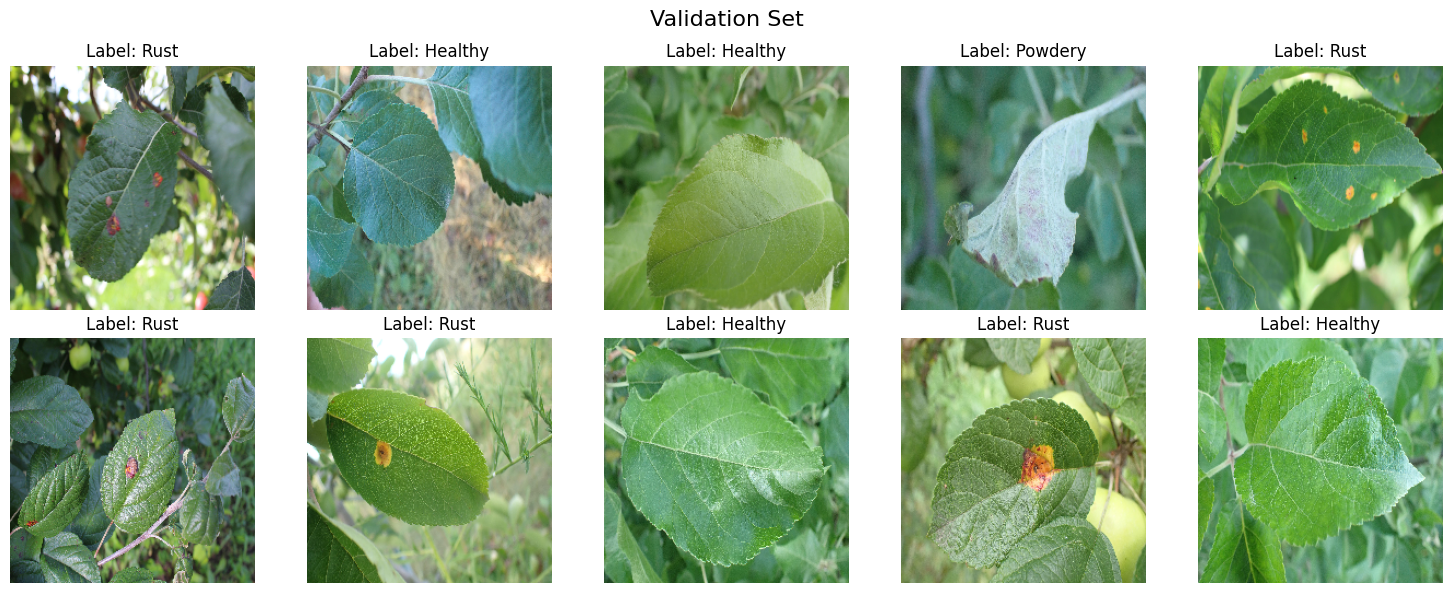

In [6]:
# Displaying the training and testing datsets
# Only 10 Images from each set

def plot_images_from_generator(generator, title, num_images=10, images_per_row=5):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for i in range(num_images):
        img = images[i]
        label = labels[i]
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {list(generator.class_indices.keys())[label.argmax()]}")
    
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_from_generator(traing, "Training Set", num_images=10, images_per_row=5)
plot_images_from_generator(testg, "Testing Set", num_images=10, images_per_row=5)
plot_images_from_generator(valg, "Validation Set", num_images=10, images_per_row=5)

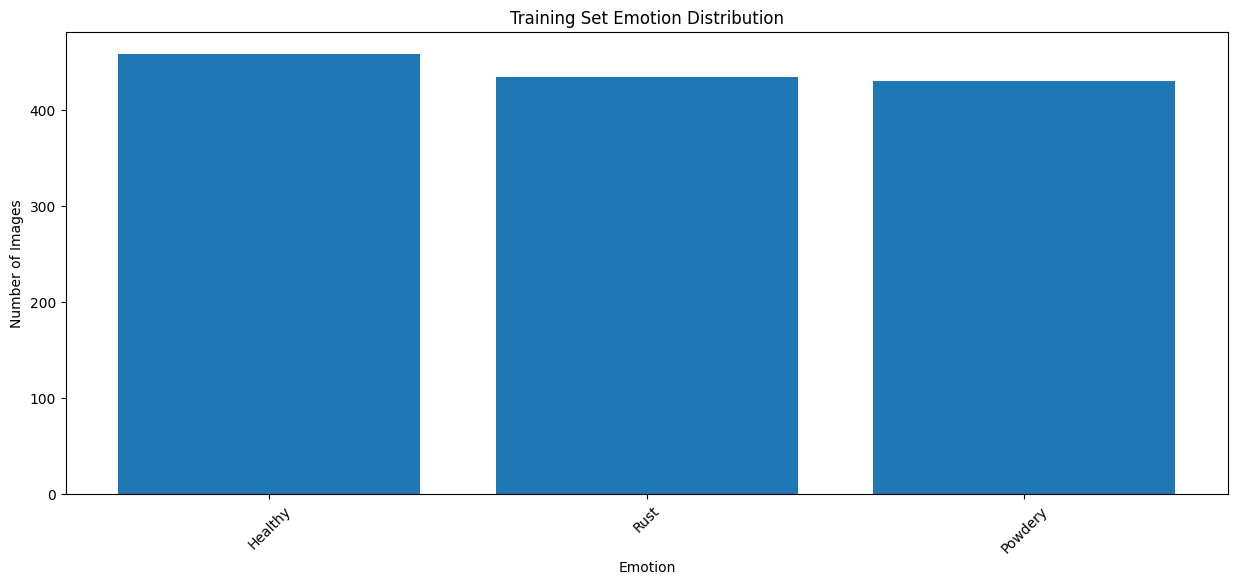

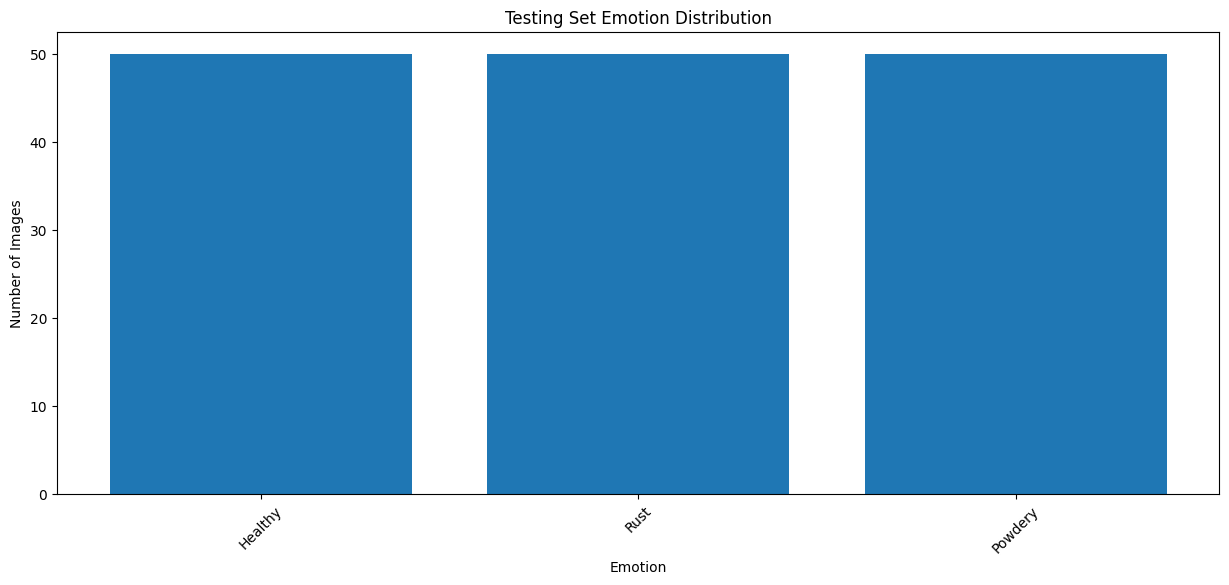

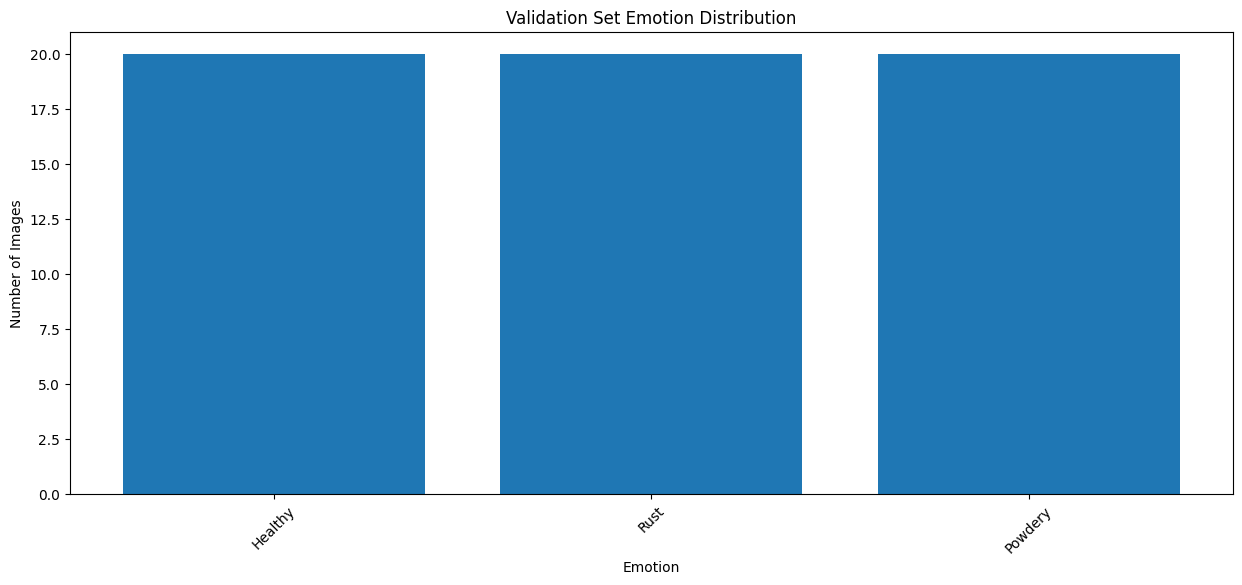

In [7]:
#class distribution

def plot_class_distribution(directory, title):
    class_names = os.listdir(directory)
    class_counts = []
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts.append(len(os.listdir(class_dir)))

    plt.figure(figsize=(15, 6))
    plt.bar(class_names, class_counts)
    plt.title(title)
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train, "Training Set Emotion Distribution")
plot_class_distribution(test, "Testing Set Emotion Distribution")
plot_class_distribution(val, "Validation Set Emotion Distribution")

****
# CNN Model
****

In [8]:
model = Sequential()

# CNN Layer 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(224, 224, 3)))  
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#CNN Layer 2
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#CNN Layer 3
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Global Average Pooling layer is used instead of Flatten as it is more effiecient
#Note: There is feature loss when we use GAP
model.add(GlobalAveragePooling2D())

#Dense Layer 1
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Dense Layer 2
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Dense Layer 3
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Output Layer
model.add(Dense(3, activation='softmax'))

#Adam Optimizer
opt = k.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1764786379.942034      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,115,203 (4.25 MB)

 Trainable params: 1,110,851 (4.24 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [9]:
# Some callbacks to help us 
# I will be using EarlyStopping and Reduce Learining Rate
es=EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
lr=ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, verbose=1, min_delta=0.0001)

callbacks_list=[es,lr]

In [10]:
# Fit the model :)
history = model.fit(
    traing,
    epochs=70,
    validation_data=valg,
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70


I0000 00:00:1764786394.564600     131 service.cc:148] XLA service 0x7d00c0106940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764786394.565445     131 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764786395.277595     131 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/42 ━━━━━━━━━━━━━━━━━━━━ 10:30 15s/step - accuracy: 0.2812 - loss: 2.3818

I0000 00:00:1764786403.157277     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.5154 - loss: 1.5011 - val_accuracy: 0.3333 - val_loss: 1.1531 - learning_rate: 0.0010
Epoch 2/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6675 - loss: 0.9688 - val_accuracy: 0.3333 - val_loss: 1.6952 - learning_rate: 0.0010
Epoch 3/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7392 - loss: 0.7494 - val_accuracy: 0.3833 - val_loss: 1.8867 - learning_rate: 0.0010
Epoch 4/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7523 - loss: 0.6581 - val_accuracy: 0.3333 - val_loss: 2.0764 - learning_rate: 0.0010
Epoch 5/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7979 - loss: 0.5543 - val_accuracy: 0.3333 - val_loss: 2.3309 - learning_rate: 0.0010
Epoch 6/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8169 - loss: 0.5123 - val_accuracy: 0.3333 - val_loss: 3.1156 - learning_rate: 0.0010
Epoch 7/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8372 - loss: 0.4888 - val_accuracy: 0.4500 - v

****
# Prediction 
****

In [11]:
# Predicting
y_pred = np.argmax(model.predict(testg), axis=1)
y_true = testg.classes


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


****
# Evaluation Metrics
****

Accuracy:  0.8666666666666667
Recall:  0.8666666666666667
Precision:  0.8897807506503159
F1 Score:  0.8684606198773274
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83        50
           1       0.96      0.88      0.92        50
           2       0.97      0.76      0.85        50

    accuracy                           0.87       150
   macro avg       0.89      0.87      0.87       150
weighted avg       0.89      0.87      0.87       150



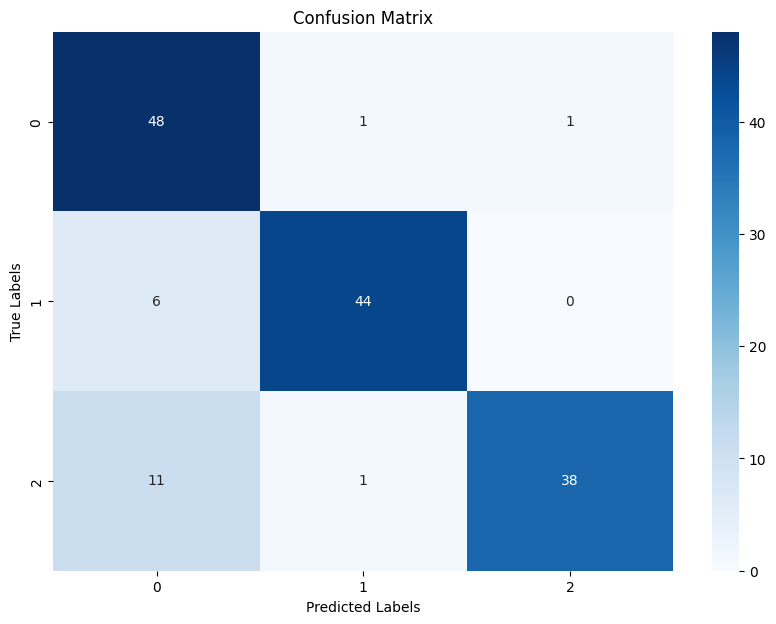

Training class indices: {'Healthy': 0, 'Powdery': 1, 'Rust': 2}
Test class indices: {'Healthy': 0, 'Powdery': 1, 'Rust': 2}


In [12]:
print('Accuracy: ',accuracy_score(y_true, y_pred))
print('Recall: ',recall_score(y_true, y_pred,average='weighted'))
print('Precision: ',precision_score(y_true, y_pred,average='weighted'))
print('F1 Score: ',f1_score(y_true, y_pred,average='weighted'))

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            )
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print Training and Test Class Indices
print("Training class indices:", traing.class_indices)
print("Test class indices:", testg.class_indices)


In [13]:
model.save('/kaggle/working/plant_disease_model.h5')
print("✅ الموديل اتحفظ!")

✅ الموديل اتحفظ!
